# Figures 5 and 6: Statistic choice

In [1]:
from concurrent.futures import ProcessPoolExecutor, as_completed
import gzip
from pathlib import Path
import pickle
import warnings

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats

import hypney.all as hp

import common
from common import draw_limits, sketch_dist, log_x

mu_signal = hp.DEFAULT_RATE_GRID
signal = hp.uniform().fix_except('rate')
plt.rcParams["text.usetex"] =  True

## Setup different statistics

In [2]:
def signed_lr(n, mu):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        with np.errstate(divide='ignore'):
            return np.where(
                n == 0,
                -2 * mu,
                -2 * np.sign(n - mu) * ((n - mu) + n * np.log(mu/n)))

statistics = dict(
    g = dict(
        dist_filename='lr_gaps',
        stat_class=hp.AllRegionSimpleHawk,
        regions_n_max=0,
        label='Gaps',
        color='k', linestyle=':'),
    lr = dict(
        f=signed_lr,
        stat_class=hp.AllRegionSimpleHawk,
        dist_filename='lr_all',
        label='$t_0$', #', likelihood ratio',
        color='orangered'),
#     lr_r = dict(
#         stat_class=hp.AllRegionSimpleHawk,
#         dist_filename='lr_oneside',
#         regions_type='right',
#         label='$t$, $R$', #', likelihood ratio',
#         color='orangered', linestyle='--'),
    p_n = dict(
        f=lambda n, mu: stats.poisson(mu).cdf(n),
        dist_filename='pn_all',
        stat_class=hp.PNAllRegionHawk,
        label=r'$P_n$', # = P(N \leq n)$',
        color='g'),
    y = dict(
        f=lambda n, mu: (n - mu)/mu**0.5,
        dist_filename='y_all',
        stat_class=hp.YAllRegionHawk,
        label='$\chi$',# = (n-\mu)/\sqrt{\mu}$',
        color='b'),
#     y_s01 = dict(
#         dist_filename='y_all_soft0.1',
#         stat_class=partial(hp.YAllRegionHawk, softness=0.1),
#         label=r'$y$, $\alpha=0.1$',# = (n-\mu)/\sqrt{\mu}$',
#         color='darkblue'),
#     y_s02 = dict(
#         dist_filename='y_all_soft0.2',
#         stat_class=partial(hp.YAllRegionHawk, softness=0.2),
#         label=r'$y$, $\alpha=0.2$',# = (n-\mu)/\sqrt{\mu}$',
#         color='indigo'),
    cn = dict(
        label=r'$C_n',
        stat_class=hp.YellinCNHawk,
        dist_filename='yellin_cn_149max',
        color='purple')
)

Build distribution for Yellin CN hawk (smaller mu grid, since we only computed the CN table up to ~150)

In [3]:
_q = np.arange(0.1, 2.1, 0.1).tolist()
# Advance by 5%, or 0.25 * sigma, whichever is lower.
# Until 150, i.e. +5 sigma if true signal is 100.
# This way, we should get reasonable results for signals < 100
# even if there is some unknown background
while _q[-1] < 150:
    _q.append(min(
        _q[-1] + 0.25 * _q[-1]**0.5,
        _q[-1] * 1.05
        ))
mus = np.asarray(_q[1:-1])
mus.min(), mus.max()
hp.YellinCNHawk(signal).with_stored_dist(
    'yellin_cn_149max',
    n_toys=10000,
    rate_anchors=mus.tolist()
);

## Indifference plots

In [4]:
mu_ref = 6

common_linestyle = dict(linewidth=1, alpha=1)
faint_style = dict(linewidth=0.5)

For statistics other than CN

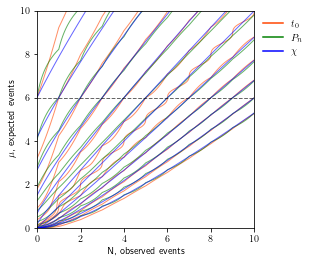

In [5]:
ns = np.arange(12)
mus = np.geomspace(1e-4, 1000, 10_000)
# ns = np.arange(20)
# mus = np.geomspace(1e-4, 100, 10_00)

alpha = 0.6

for sname, s in statistics.items():
    if not 'f' in s:
        continue
    s['nmu_values'] = s['f'](ns[None,:], mus[:,None])
  
    ref_values = s['f'](ns, mu_ref)
    np.argmin(np.min(s['nmu_values'] - ref_values))

    # Matplotlib's contour introduces several odd waves
    plt.contour(
        ns, 
        mus, 
        s['nmu_values'], 
        levels=s['f'](ns, mu_ref),
        linestyles='-',
        linewidths=1,
        alpha=alpha,
        colors=s['color'])

plt.axhline(mu_ref, c='k', linestyle='--', linewidth=1, alpha=alpha)
    
ax = plt.gca()
ax.set_aspect('equal')
plt.xlabel("N, observed events")
plt.ylabel("$\mu$, expected events")
plt.xlim(0, 10)
plt.ylim(0, 10)

# Dummy plots and legend
for sname, s in statistics.items():
    if not 'f' in s:
        continue
    plt.plot([0], [0], c=s['color'], label=s['label'])
plt.legend(loc='upper left', bbox_to_anchor=(1,1), frameon=False)

Indifference computation for non-CN

In [6]:
for sname, s in statistics.items():
    if not 'f' in s:
        continue

    s['nmu_indiff'] = r = np.zeros((ns.size, ns.size))
    for n in ns:
        # How does t changes on this n, vs mu?
        t_vs_mu = s['f'](n, mus)
        for m in ns:
            # At which mu does t(n | mu) equal t(m | ref_mu)?
            dif = t_vs_mu - s['f'](m, mu_ref)
            if np.unique(np.sign(dif)).size == 1:
                # Only as mu -> 0 where they both approach -inf.
                continue
            else:
                r[n, m] = mus[np.argmin(np.abs(dif))]
                

Alternate indifference plot

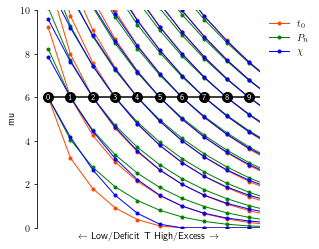

In [7]:
plt.figure(figsize=(4,4))

for sname, s in statistics.items():
    if not 'f' in s:
        continue
    for n, r in enumerate(s['nmu_indiff']):
        plt.plot(ns, r, 
                 label=s['label'] if n == 0 else None,
                 marker='.',
                 c=s['color'], **common_linestyle)
        
plt.plot(ns, np.full(ns.shape, mu_ref), marker='o', c='k', markersize=10)
for n in ns:
    plt.text(n, mu_ref, str(n), c='w', ha='center', va='center', fontsize=8)

plt.legend(loc='upper left', bbox_to_anchor=(1,1), frameon=False)
    #plt.xlabel("N observed")
plt.xticks([])
pad = " " * 10
plt.xlabel("← Low/Deficit " + pad + "T" + pad + " High/Excess →")
plt.ylabel("mu")
plt.ylim(0, 10)
#plt.yscale('log')
#plt.ylim(0.1, 10)
plt.xlim(-0.5, 9.5)

ax = plt.gca()
for side in ('top', 'right', 'bottom'):
    ax.spines[side].set_visible(False)

Indifference computation for CN

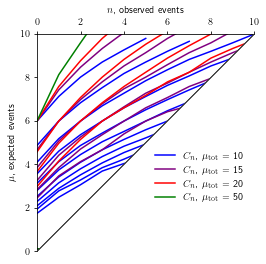

In [8]:
mus_cn = np.geomspace(0.1, 100, 1000)

cns = {
    10: dict(color='b'),
    15: dict(color='purple'),
    20: dict(color='r'),
    50: dict(color='g'),
}
for mu_tot, cn in cns.items():
    # frac = mu / mu_tot
    cn['f'] = lambda n, mu: hp.p_smaller_itv(n, mu, mu/mu_tot)
    cn['label'] = r'$C_n$, $\mu_\mathrm{tot}$ = ' + str(mu_tot)

for mu_tot, s in cns.items():
    s['nmu_indiff'] = r = np.zeros((ns.size, ns.size))
    for n in ns:
        # How does t changes on this n, vs mu?
        t_vs_mu = s['f'](n, mus_cn)
        for m in ns:
            # At which mu does t(n | mu) equal t(m | ref_mu)?
            ref_value = s['f'](m, mu_ref)
            if np.isnan(ref_value):
                r[n, m] = float('nan')
                continue

            dif = t_vs_mu - ref_value
            mask = ~np.isnan(t_vs_mu)
            if np.unique(np.sign(dif[mask])).size == 1:
                # ???
                r[n, m] = float('nan')
            else:
                r[n, m] = mus_cn[mask][np.argmin(np.abs(dif[mask]))]


plt.figure(figsize=(4,4))
ax = plt.gca()

for mu_tot, s in cns.items():
    for n, r in enumerate(s['nmu_indiff'].T):
        plt.plot(ns, r, 
                 label=s['label'] if n == 0 else None,
                 color=s['color'])

plt.legend(loc='upper left', 
           bbox_to_anchor=(0.5,0.5), 
           frameon=False)
        
ax.set_aspect('equal')
plt.xlabel("$n$, observed events")
plt.ylabel("$\mu$, expected events")
plt.xlim(0, 10)
plt.ylim(0, 10)

ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 
for side in 'bottom', 'right':
    ax.spines[side].set_visible(False)
plt.fill_between(mus, 0, mus, color='w', zorder=3)
plt.axvspan(10, 10.1, color='w', zorder=3)
plt.plot(mus, mus, color='k', zorder=5, linewidth=1)
                

Combined indifference plot

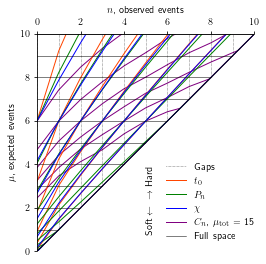

In [9]:
plt.figure(figsize=(4,4))
ax = plt.gca()

for n in ns:
    plt.axvline(n, label='Gaps' if n == 0 else None,
                c='k', **faint_style, linestyle=':')

for sname, s in statistics.items():
    if not 'f' in s:
        continue
    for n, r in enumerate(s['nmu_indiff'].T):
        plt.plot(ns, r, 
                 label=s['label'] if n == 0 else None,
                 color=s['color'], **common_linestyle)
        
for mu_tot, s in cns.items():
    if mu_tot != 15:
        continue
    for n, r in enumerate(s['nmu_indiff'].T):
        plt.plot(ns, r, 
                 label=s['label'] if n == 0 else None,
                 zorder=-2,
                 color=statistics['cn']['color'], **common_linestyle)

for n in ns:
    plt.axhline(n, c='k', **faint_style, 
                label=('Full space' if n == 0 else None))
    
plt.legend(loc='upper left', 
           bbox_to_anchor=(0.55, 0.45), 
           frameon=False)
        
ax.set_aspect('equal')
plt.xlabel("$n$, observed events")
plt.ylabel("$\mu$, expected events")
plt.xlim(0, 10)
plt.ylim(0, 10)

ax.xaxis.tick_top()
ax.xaxis.set_label_position('top') 
for side in 'bottom', 'right':
    ax.spines[side].set_visible(False)
qw = np.linspace(0, 10, 1000)
plt.fill_between(qw, -.2, qw, color='w', zorder=3, linewidth=0, clip_on=False)
plt.axvspan(10, 10.1, color='w', zorder=3)
plt.plot(mus, mus, color='k', zorder=5, linewidth=1)

# Relative position of legend and 'soft <- -> hard' text
# appears to be different for PNG and PDF. These numbers
# are to align the PDF.
plt.text(5, 2.3, r'Soft $\leftarrow \;\; \rightarrow$ Hard ', rotation=90, va='center')

for fmt in ('png', 'pdf'):
    plt.savefig(f'indifference_curves.{fmt}', dpi=200, bbox_inches='tight')

## 2d sensitivity test

(Similar to region_choice_plaw.. Much duplicated code!)

In [10]:
poisson_kind = 'augmented'
with gzip.open('poisson_sens.pkl.gz', mode='rb') as f:
    poisson_sens = pickle.load(f)
poisson_sens = poisson_sens[poisson_kind]

In [11]:
# Initialize statistics
for statname, s in statistics.items():
    kwargs = dict(signal_only=True)
    if 'regions_n_max' in s:
        kwargs['n_max'] = s['regions_n_max']    
    if 'regions_type' in s:
        kwargs['regions_type'] = s['regions_type']
    kwargs['signal_only'] = True
    s['stat'] = s['stat_class'](signal, **kwargs).with_stored_dist(
        s['dist_filename'],
        n_toys=10_000)

def draw_all_limits(alpha, *, ul, mus, n_trials, distribution_maker):
    r = np.zeros((len(mus), n_trials))
    for i, mu in enumerate(mus):
        source = distribution_maker(mu=mu, alpha=alpha)
        r[i] = draw_limits(ul, source, n_trials)
    return r

powerlaw


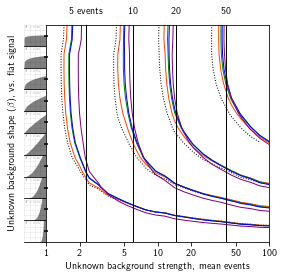

In [19]:
# (20, 15, 250) took 100 minutes to compute

# Total expected events
# (constrained to 0.2-149 due to YellinHawk)
mus = np.concatenate([
    np.array([0.2, 1]),
    np.geomspace(2, 100, 1 + 20)    #10 is low, 20 medium, 43 high?
])

# Similarity to expected signal
alphas = np.concatenate([
    [0.01], 
    np.linspace(0.05, 1, 15)])     #11 is low, medium 15, high 20?

# Number of trial limits. 100 is low. 250 medium? 1000 high?
n_trials = 1500

# Previous trial limits to load and add to
n_old = 1000

for distribution_maker, study_name, show_legend in (
#    (common.block_bg, 'block', True),
#     (staircase, 'staircase'),
#     (triangle_on_signal, 'triangle_on_signal'),
#     (beta_halfpipe, 'beta_halfpipe'),
    (common.powerlaw, 'powerlaw', False),
):
    print(study_name)

    cache_folder = Path(f'./limits_statscomp_{study_name}/')
    cache_folder.mkdir(exist_ok=True)

    ##
    # Get toy MC limits
    ##
    for statname, s in statistics.items():
        key = f'limits_{study_name}'

        cache_fn = cache_folder / f"{statname}_{n_trials}_{mus.size}_{alphas.size}.pkl.gz"
        if cache_fn.exists():
            with gzip.open(cache_fn, mode='rb') as f:
                s[key] = pickle.load(f)
        else:
            # Bahh code duplication
            if n_old:
                old_fn = cache_folder / f"{statname}_{n_old}_{mus.size}_{alphas.size}.pkl.gz"
                with gzip.open(old_fn, mode='rb') as f:
                    old_limits = pickle.load(f)

            n_to_draw = n_trials - n_old
            print(f"Drawing {n_to_draw} limits for {statname}")
            
            anchors = mu_signal[(mu_signal >= 0.2) & (mu_signal < 149)].tolist()
            ul = hp.UpperLimit(s['stat'], anchors=anchors)

            with ProcessPoolExecutor(max_workers=7) as exc:
                new_limits = np.asarray(list(
                    tqdm(
                        exc.map(
                            partial(draw_all_limits, 
                                    distribution_maker=distribution_maker,
                                    ul=ul, 
                                    mus=mus,
                                    n_trials=n_to_draw),
                            alphas),
                        desc=statname, total=len(alphas))))

            s[key] = np.concatenate([old_limits, new_limits], axis=2)

            with gzip.open(cache_fn, mode='wb') as f:
                pickle.dump(s[key], f)


    ##
    # Plot mean limits
    ##
    levels = np.array([5, 10, 20, 50])
    lw = 1

    fig = plt.figure(figsize=(4,4))

    for statname, s in statistics.items():
        if statname.startswith('y_s'):
            continue
        
        # (similarities, alphas, n_trials), average over final axis
        y = np.mean(s[f'limits_{study_name}'], axis=2)
        color = s['color']

        # Don't transpose here, x/y convention reversed like pcolormesh?
        # (if you do transpose, you get error, so...)
        plt.contour(mus, alphas, y,
                    levels=levels,
                    norm=matplotlib.colors.LogNorm(1, 100),
                    linewidths=lw, 
                    linestyles=s.get('linestyle', '-'),
                    colors=color)
        # Null line plot, so legend has something
        plt.plot([0], [0], 
                 label=s.get('label', statname), 
                 linestyle=s.get('linestyle', '-'),
                 color=color, 
                 linewidth=lw) 

    # Plot full space Poisson sensitivities
    x = np.geomspace(0.1, 100, 10_000)
    y = poisson_sens['itp'](x)
    labelpos = 1.05
    for i, l in enumerate(levels):
        # mu at which poisson sensitivity reaches l
        #p_sens = x[np.argmin(np.abs(y - l))]
        p_sens = poisson_sens['inv_itp'](l)
        plt.axvline(
            p_sens,
            color='k',
            linewidth=lw,
            label='Full space' if i == 0 else None)
        if i == 0:
            plt.text(p_sens, labelpos, f'{l} events', ha='center')
        else:
            plt.text(p_sens, labelpos, f'{l}', ha='center')

    if show_legend:
        legend = plt.legend(
            loc='upper left',
            #bbox_to_anchor=(1.1, 1),
            bbox_to_anchor=(-0.1, -0.18),
            #bbox_to_anchor=(-0.2, -0.2),
            ncol=3,
            frameon=False)

    plt.gca().xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%g'))
    plt.xlabel("Unknown background strength, mean events")
    log_x(1, 100 + 1e-9, tick_at=[1, 2, 5])
    # plt.xlim(0.5, 100)
    # plt.xscale('log')
    # plt.xticks([1, 2, 5, 10, 25, 50, 100])
    
    plt.ylabel(r"Unknown background shape ($\beta$), vs. flat signal", labelpad=29)
    plt.ylim(0, 1)
    plt.yticks([])
    
    #plt.grid(alpha=0.2, c='k', linewidth=0.2)

    #plt.title(study_name, loc='lower right')

    # Distribution sketches
    n_sketch = 10
    width = 0.1
    xpos = 0.04825
    sketch_sims = np.linspace(0, 1, n_sketch * 2 + 1)[1::2]
    plt.scatter(
        1 + 0 * sketch_sims, 
        sketch_sims, 
        marker='_', s=10, c='k', 
        clip_on=False,
        zorder=-50)
    y_start = 0.125  # y matching lower spine
    y_end = 0.882    # y matching upper spine
    width = (y_end - y_start) / n_sketch
    for i, sim in enumerate(sketch_sims):
        new_ax = fig.add_axes([xpos, y_start + i * width, 
                              width, width])
        new_ax.set_zorder(-5)
        plt.sca(new_ax)
        sketch_dist(common.powerlaw(mu=1, alpha=sim), 
                    xlabel=None, annotation=rf"$\beta = {sim:0.2f}$")

    # # Distribution sketches
    # n_sketch = 10
    # width = 0.1
    # xpos = 0.048
    # sketch_sims = np.linspace(0, 1, n_sketch + 2)[1:-1]
    # y_start = 0.125  # y matching lower spine
    # y_end = 0.882    # y matching upper spine
    # width = (y_end - y_start) / n_sketch
    # for i, sim in enumerate(sketch_sims):
    #     plt.sca(fig.add_axes([xpos, y_start + i * width, 
    #                           width, width]))
    #     sketch_dist(distribution_maker(mu=1, alpha=sim), xlabel=None)
    
    for fmt in 'png', 'pdf':
        plt.savefig(f'statscomp_{study_name}_{n_trials}.{fmt}',
                    dpi=400, bbox_inches='tight',
                    bbox_extra_artists=([legend] if show_legend else None))
    plt.show()
